# Convolutions

In this lab, we'll look in detail at convolutions and how they can be used to process images.

### Reading and opening images

We'll use the `skimage` library to read and process images. It's a library dedicated to image processing, which is part of the `scikit-learn` family.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage

sample image shape:  (400, 600, 3)


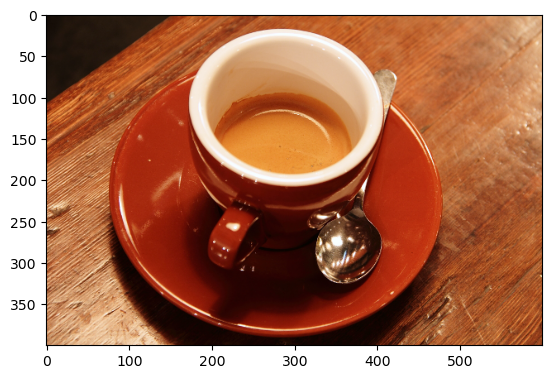

In [3]:
sample_image = skimage.data.coffee()

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

### A simple convolution filter

Before we start working on training any models, let's look at applying a convolution filter to an image. We'll use the `Conv2D` layer from Keras to do this.

In [4]:
from tensorflow.keras.layers import Conv2D

In [5]:
conv = Conv2D(filters=3, kernel_size=(5, 5), padding="same")

Remember: in Keras, `None` is used as a marker for tensor dimensions with dynamic size. In this case `batch_size`, `width` and `height` are all dynamic: they can depend on the input. This is a neat feature of convolutional neural networks: the same model can be used to process images of any size, because all we have to do is slide the convolutional filter across the image as much as necessary.

In [6]:
sample_image.shape

(400, 600, 3)

In [7]:
img_in = np.expand_dims(sample_image, 0).astype(float)
img_in.shape

(1, 400, 600, 3)

In [8]:
img_out = conv(img_in) # Apply the convolutional filter

The output is a tensorflow Eager Tensor - a special data structure that is used to represent the result of operations in TensorFlow. It is not a numpy array, but it can be converted to one using the `.numpy()` method:

In [9]:
np_img_out = img_out[0].numpy()
print(type(np_img_out))
print(np_img_out.shape)

<class 'numpy.ndarray'>
(400, 600, 3)


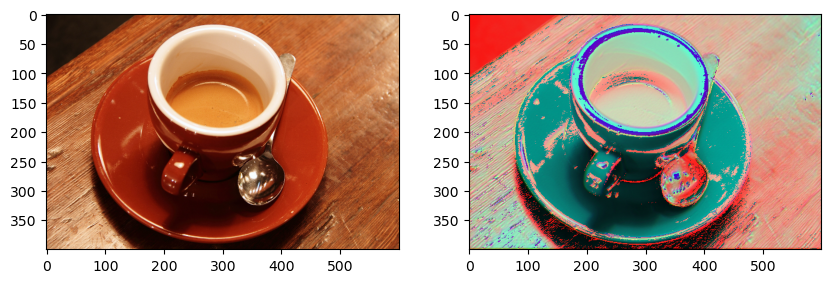

In [10]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(np_img_out.astype('uint8'));

As we can see, our convolutional filter was initialized randomly, so our output doesn't contain any specific meaning. Each pixel is a random combination of the pixels in the input image, in a 5x5 window.

Let's instead take a look at a convolutional feature with a clear purpose. We can build a kernel ourselves, by defining a function which will be passed to `Conv2D` Layer.
We'll create an array with 1/25 for filters, with each channel seperated. Before you move to the next cell, can you guess what this filter will do?

In [11]:
def my_kernel(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

Now we can use this function to initialize a `Conv2D` layer:

In [12]:
conv = Conv2D(filters=3, kernel_size=(5, 5), padding="same", kernel_initializer=my_kernel)

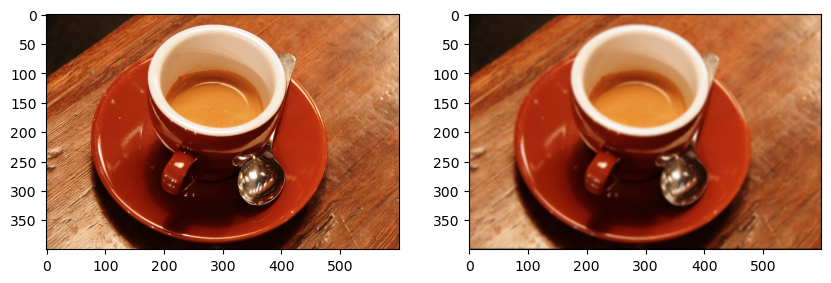

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))

img_out = conv(img_in)
np_img_out = img_out[0].numpy()
ax1.imshow(np_img_out.astype('uint8'));

Hopefully you can tell what this filter does!

**Exercise**
- There are a number of settings when we define our Conv2D layer. Try changing the following parameters to get a sense of how they impact the result:
- kernel_size: try different sizes
- padding: try 'valid' instead of 'same' (hint: this may change the size of the output)

(1, 400, 600, 3)
(1, 391, 591, 3)


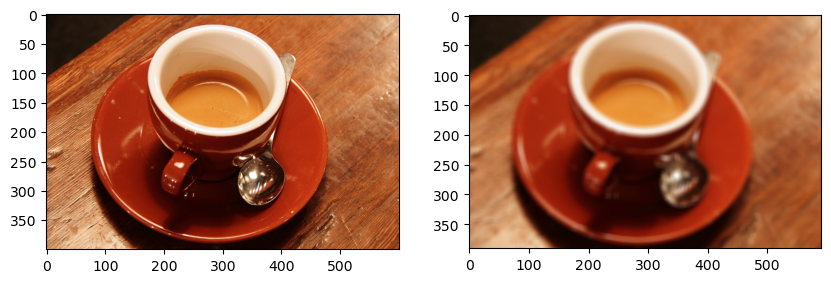

In [14]:
def my_kernel(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 100
    array[:, :, 1, 1] = 1 / 100
    array[:, :, 2, 2] = 1 / 100
    return array

conv = Conv2D(filters=3, kernel_size=(10, 10), padding="valid", kernel_initializer=my_kernel)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))

img_out = conv(img_in)
np_img_out = img_out[0].numpy()
ax1.imshow(np_img_out.astype('uint8'));

print(img_in.shape)
print(img_out.shape)

### Working on edge detection on Grayscale image

Using a grayscale image, let's build an "edge detector" using a convolutional filter. Some filters pre-date the deep learning era and are still used today. For example, the Sobel filter is used to detect edges in images. These easy-to-compute filters were used in the early days of computer vision and are still useful now.

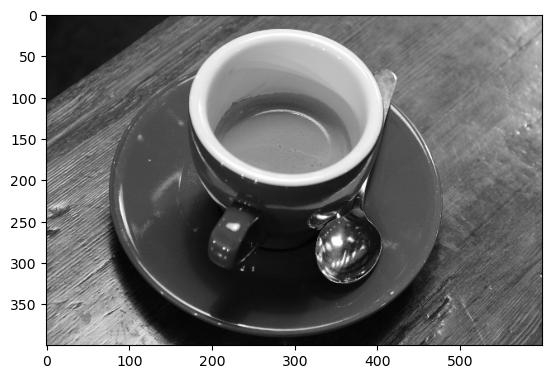

In [15]:
# convert image to greyscale
grey_sample_image = sample_image.mean(axis=2)

# add the channel dimension even if it's only one channel so
# to be consistent with Keras expectations.
grey_sample_image = grey_sample_image[:, :, np.newaxis]

# matplotlib does not like the extra dim for the color channel
# when plotting gray-level images. Let's use squeeze:
plt.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray);

**Exercise**
- Build an edge detector using `Conv2D` on greyscale image by defining the kernel inside `my_kernel`.
- You may experiment with several kernels to find a way to detect edges. The following article contains specific examples of kernels that you can use:
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- Try different kernels and see the impact on the output.

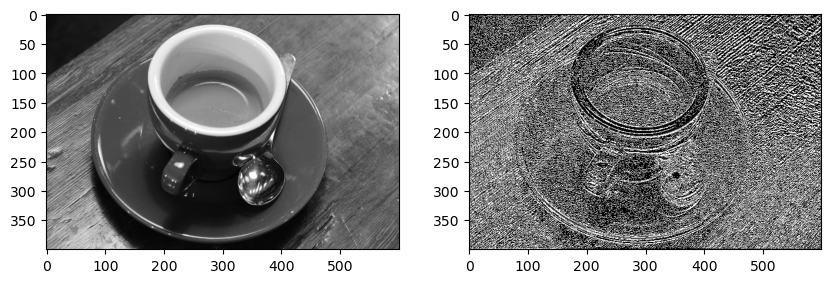

In [16]:
def my_kernel(shape=(3, 3, 1, 1), dtype=None):
    array = np.array([
        [0, -1, 0],
        [0, 2, 0],
        [0, -1, 0]
    ])
    # raise NotImplementedError("Replace the line above with your implementation")
    array = array.reshape(*shape)
    return array

conv = Conv2D(filters=1, kernel_size=(3, 3), padding="same", kernel_initializer=my_kernel)

img_in = np.expand_dims(grey_sample_image, 0) # Reshape into a batch of size 1
img_out = conv(img_in) # Apply the convolutional filter
np_img_out = img_out[0].numpy() # Convert to numpy array

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray)
ax1.imshow(np_img_out.astype(np.uint8), cmap=plt.cm.gray);


### Pooling and strides with convolutions

**Exercise**
- Use `MaxPool2D` to apply a 2x2 max pool with strides 2 to the image. What is the impact on the shape of the image?
- Use `AvgPool2D` to apply an average pooling.
- Is it possible to compute a max pooling and an average pooling with well chosen kernels?

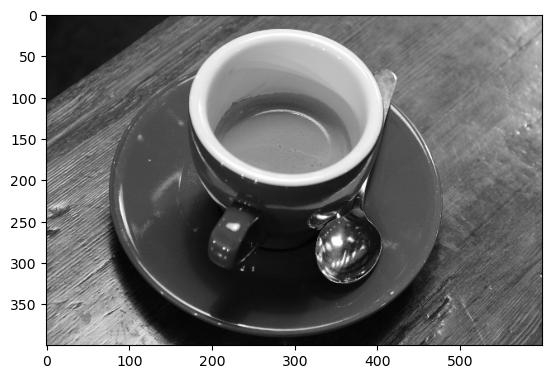

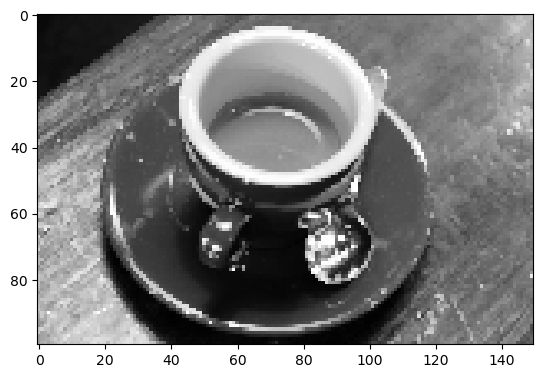

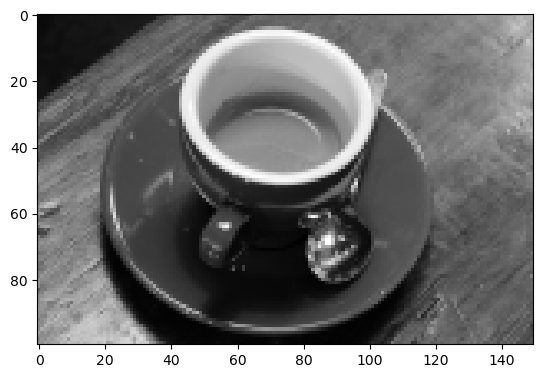

In [17]:
from tensorflow.keras.layers import MaxPool2D, AvgPool2D

# You can use `img_in` from above as input to the pooling layers

plt.figure()
plt.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray);

pool = MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding="valid")

img_out = pool(img_in)
np_img_out = img_out[0].numpy()

plt.figure()
plt.imshow(np.squeeze(np_img_out.astype(np.uint8)),
              cmap=plt.cm.gray);

pool = AvgPool2D(pool_size=(4, 4), strides=(4, 4), padding="valid")

img_out = pool(img_in)
np_img_out = img_out[0].numpy()

plt.figure()
plt.imshow(np.squeeze(np_img_out.astype(np.uint8)),
                cmap=plt.cm.gray);

## Loading a JPEG file as a numpy array

Let's use [scikit-image](http://scikit-image.rg) to load the content of a JPEG file into a numpy array:

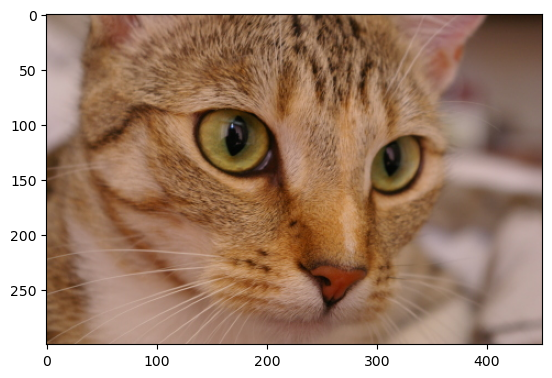

In [18]:
from skimage.io import imread

image = skimage.data.cat()
plt.imshow(image);

## Resizing images, handling data types and dynamic ranges

While convolutions can handle inputs of any size, it is often useful to resize images to a fixed size. This is particularly important for training deep learning models:

- for **image classification**, most networks expect a specific **fixed input size**;

- for **object detection** and instance segmentation, networks have more flexibility but the image should have **approximately the same size as the training set images**.

Furthermore **large images can be much slower to process** than smaller images (the number of pixels varies quadratically with the height and width).

In [19]:
from skimage.transform import resize

lowres_image = resize(image, (50, 50), mode='reflect', anti_aliasing=True)
lowres_image.shape

(50, 50, 3)

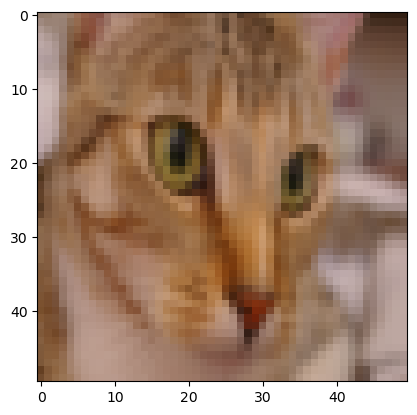

In [20]:
plt.imshow(lowres_image, interpolation='nearest');

The values of the pixels of the low resolution image are computed from by combining the values of the pixels in the high resolution image. The result is therefore represented as floating points.

## Using a pretrained model

Objectives:

- Load a pre-trained ResNet50 pre-trained model using Keras Zoo
- Use the model to classify an image
- Use the model to classify an image from the webcam

Let's start with loading ResNet50, a well-established method for image classification. The ResNet50 "application" takes two key parameters here: firstly, `include_top` indicates whether we want to include the last layer of the network (the classification layer) or not. Secondly, `weights` indicates whether we want to load the weights of a model that has been pre-trained on ImageNet or not.

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=True, weights='imagenet')
model.compile(optimizer='sgd', loss='categorical_crossentropy')

In [22]:
print(model.summary())

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


### Classification of an image

**Exercise**
- Reshape the `cat` image to the shape `(224, 224, 3)` using `resize` from `skimage.transform`
- Use `preprocess_input` from `tensorflow.keras.applications.imagenet_utils` to preprocess the image
- Use `predict` to classify the image

Documentation for each method:
- [resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize)
- [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input)
- [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

In [26]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

print(f'Original cat image value range: {image.min()} - {image.max()}')
resized_image = resize(image, (224, 224))
resized_image.shape
print(f'Range of values in resized image: {resized_image.min()} - {resized_image.max()}')

cat_image = (resized_image * 255).astype("float32")

cat_image = preprocess_input(cat_image)
print(f'Preprocessed value range: {cat_image.min()} - {cat_image.max()}')

image_batch = np.expand_dims(cat_image, axis=0) 

predictions = model.predict(image_batch)
decoded = decode_predictions(predictions, top=5)[0]

for i, (imagenet_id, label, score) in enumerate(decoded):
    print(f"{i + 1}: {label} ({score:.2f})")

Original cat image value range: 0 - 231
Range of values in resized image: 0.0025288084839353467 - 0.8271664419096498
Preprocessed value range: -119.4090805053711 - 87.24744415283203
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1: Egyptian_cat (0.96)
2: tiger_cat (0.02)
3: tabby (0.02)
4: shower_cap (0.00)
5: plastic_bag (0.00)


##  Taking snapshots from the webcam

For this section, we will take an image from your laptop webcam and classify it. If you feel uncomfortable doing this section, you can skip it and use a photo of your choice from the web instead.

In [29]:
import cv2

def camera_grab(camera_id=0, fallback_filename=None):
    camera = cv2.VideoCapture(camera_id)
    try:
        # take 10 consecutive snapshots to let the camera automatically tune
        # itself and hope that the contrast and lighting of the last snapshot
        # is good enough.
        for i in range(10):
            snapshot_ok, image = camera.read()
        if snapshot_ok:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = imread(fallback_filename)
    finally:
        camera.release()
    return image

[ WARN:0@717.857] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


dtype: uint8, shape: (720, 1280, 3), range: (0, 255)


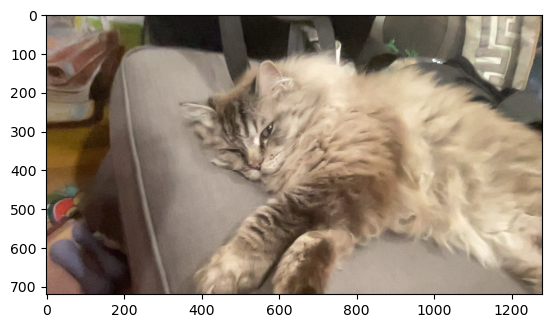

In [30]:
image = camera_grab(camera_id=0, fallback_filename=None)
plt.imshow(image)
print("dtype: {}, shape: {}, range: {}".format(
    image.dtype, image.shape, (image.min(), image.max())))


### Exercise

Apply the same preprocessing as before and classify the image. What are your results?

In [31]:
print(f'Original me image value range: {image.min()} - {image.max()}')
resized_image = resize(image, (224, 224))
resized_image.shape
print(f'Range of values in resized image: {resized_image.min()} - {resized_image.max()}')

me_image = (resized_image * 255).astype("float32")

me_image = preprocess_input(me_image)
print(f'Preprocessed value range: {me_image.min()} - {me_image.max()}')

image_batch = np.expand_dims(me_image, axis=0) 

predictions = model.predict(image_batch)
decoded = decode_predictions(predictions, top=5)[0]

for i, (imagenet_id, label, score) in enumerate(decoded):
    print(f"{i + 1}: {label} ({score:.2f})")

Original me image value range: 0 - 255
Range of values in resized image: 0.013914305440932721 - 0.989369572147015
Preprocessed value range: -110.92453002929688 - 133.64248657226562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1: dishwasher (0.53)
2: printer (0.03)
3: computer_keyboard (0.03)
4: mouse (0.03)
5: Persian_cat (0.02)


[ WARN:0@787.131] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


dtype: uint8, shape: (720, 1280, 3), range: (0, 255)


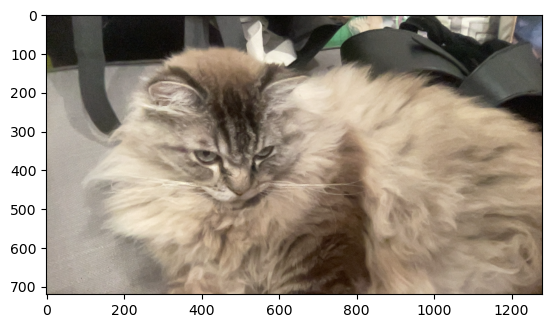

In [32]:
image = camera_grab(camera_id=0, fallback_filename=None)
plt.imshow(image)
print("dtype: {}, shape: {}, range: {}".format(
    image.dtype, image.shape, (image.min(), image.max())))

In [33]:
print(f'Original me image value range: {image.min()} - {image.max()}')
resized_image = resize(image, (224, 224))
resized_image.shape
print(f'Range of values in resized image: {resized_image.min()} - {resized_image.max()}')

me_image = (resized_image * 255).astype("float32")

me_image = preprocess_input(me_image)
print(f'Preprocessed value range: {me_image.min()} - {me_image.max()}')

image_batch = np.expand_dims(me_image, axis=0) 

predictions = model.predict(image_batch)
decoded = decode_predictions(predictions, top=5)[0]

for i, (imagenet_id, label, score) in enumerate(decoded):
    print(f"{i + 1}: {label} ({score:.2f})")

Original me image value range: 0 - 255
Range of values in resized image: 0.019188464210838203 - 0.9881996675180136
Preprocessed value range: -115.60421752929688 - 133.31082153320312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1: Persian_cat (0.38)
2: lynx (0.06)
3: fur_coat (0.04)
4: Angora (0.03)
5: tabby (0.03)
